# Week 4 homework.

This home is week 4 homework looking at the model evaluation matrices.

### Load the libraries neede for the analysis

In [73]:
## Import the modules needed for the analys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import seaborn as sns

%matplotlib inline

### Get the data using wget

In [2]:
#!wget  'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'

### Read in the dataset using pandas read_csv

Read in the data and get the columns needed for the analysis

In [3]:
## read in the data
df = pd.read_csv('bank-full.csv', sep=";")

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
need_columns = ['age','job','marital','education','balance','housing',
'contact','day','month','duration','campaign','pdays','previous','poutcome','y']

In [6]:
bank_df = df[need_columns]

In [7]:
bank_df.y = (df.y == 'yes').astype(int)

/var/folders/js/95x7pm0d46d9qsgdhmvy56400000gn/T/ipykernel_13227/2138537326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_df.y = (df.y == 'yes').astype(int)


## Split the dataset into train/test/validation

In [8]:
df_full_train, df_test = train_test_split(bank_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.y.values
y_test = df_test.y.values
y_val = df_val.y.values

del df_train['y']
del df_test['y']
del df_val['y']

In [9]:
numeric_data = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that
- If your AUC is < 0.5, invert this variable by putting "-" in front

`(e.g. -df_train['engine_hp'])`

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [17]:
for num in numeric_data:
    auc = roc_auc_score(y_train, df_train[num])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[num])
    print('AUC for is %9s, %.5f' % (num, auc))

AUC for is       age, 0.51219
AUC for is   balance, 0.58883
AUC for is       day, 0.52596
AUC for is  duration, 0.81470
AUC for is  campaign, 0.57145
AUC for is     pdays, 0.59013
AUC for is  previous, 0.59857


#### Plot the AUC for all the 

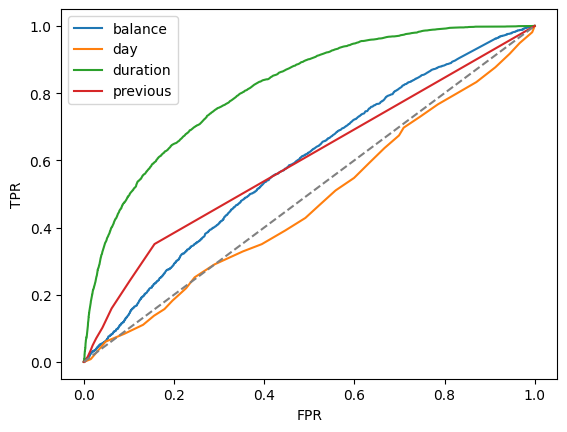

In [36]:
values = ['balance', 'day','duration','previous']
for i in values:
    fpr, tpr, _ = roc_curve(y_train, df_train[i])
    plt.plot(fpr, tpr, label=i)


plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
    

### Question 2: Training the model
Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99


#### Train the moddel

In [39]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numeric_data].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [45]:
val_dicts = df_val[categorical + numeric_data].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = y_pred >0.5
accuracy = (y_val == churn_decision).mean()

ROC = roc_auc_score(y_val, y_pred)
ROC

0.9000611291793008

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
  
At which threshold precision and recall curves intersect?
- 0.265
- 0.465
- 0.665
- 0.865

In [51]:
def trp_fpr_dataframe (y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        acttual_postive = (y_val == 1)
        acttual_negative = (y_val == 0)
        
        predict_postive = (y_pred >= t)
        predict_negative = (y_pred < t)
        
        tp = (predict_postive & acttual_postive).sum()
        tn = (predict_negative & acttual_negative).sum()
    
        fp = (predict_postive & acttual_negative).sum()
        fn = (predict_negative & acttual_postive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
    score_df = pd.DataFrame(scores, columns=columns)
    score_df['tpr'] = score_df.tp / (score_df.tp + score_df.fn)
    score_df['fpr'] = score_df.fp / (score_df.fp + score_df.tn)

    return score_df

In [55]:
scores = trp_fpr_dataframe(y_val, y_pred)

scores['precision'] = scores.tp / (scores.tp + scores.fp)
scores['recall'] = scores.tp / (scores.tp + scores.fn)

In [56]:
scores[::10]

,thresholds,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.0,1098,7944,0,0,1.000000,1.000000,0.121433,1.000000
10,0.1,929,1508,169,6436,0.846084,0.189829,0.381206,0.846084
20,0.2,709,702,389,7242,0.645719,0.088369,0.502481,0.645719
30,0.3,568,414,530,7530,0.517304,0.052115,0.578411,0.517304
40,0.4,463,273,635,7671,0.421676,0.034366,0.629076,0.421676
50,0.5,365,191,733,7753,0.332423,0.024043,0.656475,0.332423
60,0.6,291,133,807,7811,0.265027,0.016742,0.686321,0.265027
70,0.7,224,104,874,7840,0.204007,0.013092,0.682927,0.204007
80,0.8,147,67,951,7877,0.133880,0.008434,0.686916,0.133880
90,0.9,76,30,1022,7914,0.069217,0.003776,0.716981,0.069217


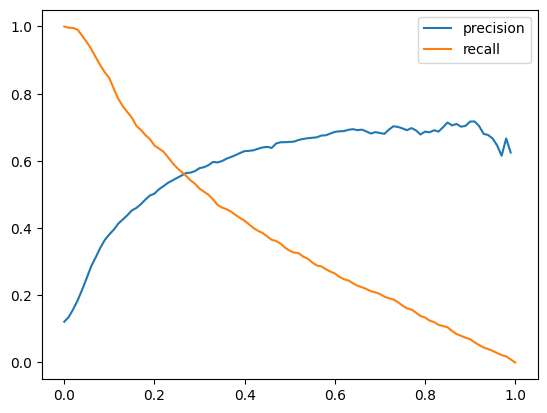

In [58]:
plt.plot(scores.thresholds, scores.precision, label='precision')
plt.plot(scores.thresholds, scores.recall, label='recall')

plt.legend()
plt.show()

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F: 2 x((pxr)/(P+R))

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [59]:
scores['f1'] = 2 * scores.precision * scores.recall / (scores.precision + scores.recall)

In [67]:
scores[scores.f1==max(scores.f1)]

,thresholds,tp,fp,fn,tn,tpr,fpr,precision,recall,f1
22,0.22,689,624,409,7320,0.627505,0.07855,0.524752,0.627505,0.571547


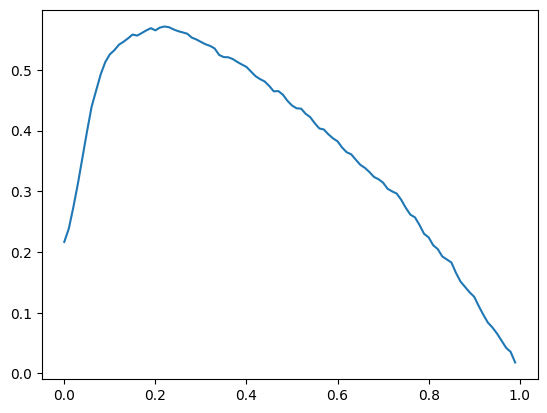

In [61]:
plt.plot(scores.thresholds, scores.f1)

## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [84]:
from tqdm.auto import tqdm
import warnings
warnings.simplefilter("ignore")

##### Define the function needed for Questions 5 and 6

In [97]:
def train(df, y, C=1.0):
    dicts = df[categorical + numeric_data].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numeric_data].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


##### Train the model and determine the mean and std

In [100]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)   
for train_idx, val_idx in kfold.split(df_full_train):     
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values
    
    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)
    
    
    roc = roc_auc_score(y_val, y_pred)
    scores.append(roc)

print('%.3f +- %.3f' % (np.mean(scores),np.std(scores)))

0.906 +- 0.006


### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

`Iterate over the following C values: [0.000001, 0.001, 1]`
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [101]:
n_split = 5
for C in tqdm([0.000001, 0.001, 1]):    
    kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)

    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):     
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        
        roc = roc_auc_score(y_val, y_pred)
        scores.append(roc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores),np.std(scores)))


 33%|███████████████████████████████████████████████████████████▋                                                                                                                       | 1/3 [00:02<00:04,  2.13s/it]

C=1e-06 0.701 +- 0.009


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2/3 [00:04<00:02,  2.32s/it]

C=0.001 0.861 +- 0.007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.41s/it]

C=1 0.906 +- 0.006
